In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import time

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

# I - Vanilla classification with pretrained VGG

In [ ]:
#To remove
import zipfile
with zipfile.ZipFile("landmark.zip", 'r') as zip_ref:
    zip_ref.extractall("./landmark")

## Prepare dataset

### Unzip data

In [30]:
import zipfile

with zipfile.ZipFile("aligned.zip", 'r') as zip_ref:
    zip_ref.extractall("./aligned")

In [31]:
!mkdir aligned/train
!mkdir aligned/test
!mv aligned/aligned/train_* aligned/train
!mv aligned/aligned/test_* aligned/test

### Prepare csv labels

In [32]:
import csv
# Creation des labels sous formats csv

with open("list_patition_label.txt","r") as file :
    train_csv = open("train_list_label.csv","w",newline="")
    test_csv = open("test_list_label.csv","w",newline="")

    train_writer = csv.writer(train_csv)
    train_writer.writerow(["Filename", "Label"])
    
    test_writer = csv.writer(test_csv)
    test_writer.writerow(["Filename", "Label"])
    
    
    for line in file:
        filename, label = line.strip().split(" ")
        idx = filename.index(".jpg")
        filename = filename[:idx] + "_aligned" + filename[idx:]
        label = str(int(label) - 1)
        
        if "train" in filename :
            train_writer.writerow([filename, label])
        else :
            test_writer.writerow([filename, label])


### Preprocessing transform

In [34]:
trans = transforms.Compose([
    transforms.Lambda(lambda x: x.float()),
    transforms.Resize((224,224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip()
])

### Create dataloaders (split is train/test/val = 80/10/10)

In [35]:
import pandas as pd
import os
from torch.utils.data import Dataset
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [36]:
train_data = CustomImageDataset("train_list_label.csv","./aligned/train", transform=trans)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=4)
print(f"\nNb batches in train: {len(train_loader)}")


Nb batches in train: 767


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [64]:
from sklearn.model_selection import train_test_split
test_data = CustomImageDataset("test_list_label.csv","./aligned/test", transform=trans)

test_indices, val_indices = train_test_split(list(range(len(test_data.img_labels.Label))), test_size=0.5, stratify=test_data.img_labels.Label)

val_data = torch.utils.data.Subset(test_data, val_indices)
test_data = torch.utils.data.Subset(test_data, test_indices)


In [65]:
test_loader = DataLoader(test_data, batch_size=16, shuffle=True, num_workers=4)
print(f"\nNb batches in test: {len(test_loader)}")


Nb batches in test: 96


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [66]:
val_loader = DataLoader(val_data, batch_size=16, shuffle=True, num_workers=4)
print(f"\nNb batches in val: {len(val_loader)}")


Nb batches in test: 96


## VGG class

In [38]:

import torch
import torch.nn as nn


class Vgg(nn.Module):

    def __init__(self):
        super(Vgg, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Linear(in_features=25088, out_features=4096, bias=True)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout6 = nn.Dropout(p=0.5)
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout7 = nn.Dropout(p=0.5)
        self.fc8 = nn.Linear(in_features=4096, out_features=2622, bias=True)

    def forward(self, x0):
        x1 = self.conv1_1(x0)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31_preflatten = self.pool5(x30)
        x31 = x31_preflatten.view(x31_preflatten.size(0), -1)
        x32 = self.fc6(x31)
        x33 = self.relu6(x32)
        x34 = self.dropout6(x33)
        x35 = self.fc7(x34)
        x36 = self.relu7(x35)
        x37 = self.dropout7(x36)
        x38 = self.fc8(x37)
        return x38

def vgg_face(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

### Load pretrained weights on vgg_face

In [ ]:
vgg = vgg_face("vgg_face_dag.pth")
vgg.fc8 = nn.Linear(in_features=4096, out_features=7, bias=True)
vgg = vgg.to(device)

## Train

### Initial evaluation on val dataset

In [47]:
def eval_model(net, loader, loss_fn):
  net.eval()
  acc, loss = 0., 0.
  c = 0
  for x, y in loader:
    with torch.no_grad():
      # No need to compute gradient here thus we avoid storing intermediary activations
      
      logits = net(x.to(device)).cpu()

    loss += loss_fn(logits, y).item()
    preds = logits.argmax(dim=1)
    acc += (preds.numpy() == y.numpy()).sum()
    c += len(x)
    break

  acc /= c
  loss /= len(loader)
  net.train()
  return acc, loss

In [72]:
cross_entropy = nn.CrossEntropyLoss() 

initial_acc, initial_loss = eval_model(vgg, val_loader, cross_entropy)
print(f"Initial accuracy/loss on val: {round(100 * initial_acc, 2)}/{round(initial_loss, 4)}")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Initial accuracy/loss on val: 56.25/0.0106


### Training

In [ ]:
optimizer = torch.optim.Adam(vgg.parameters(), lr=0.00005)

nb_epochs = 75

train_accs, train_losses = [], []
val_accs, val_losses = [], []

In [56]:
from tqdm import tqdm
for epoch in range(nb_epochs):

  with tqdm(train_loader, unit="batch") as tepoch:
    start = time.time()
    running_acc, running_loss = 0., 0.
    c = 0
    for x, y in tepoch:
      x, y = x.to(device), y.to(device)

      optimizer.zero_grad()  # Clear previous gradients
      logits = vgg(x)
      loss = cross_entropy(logits, y)
      loss.backward()  # Compute gradients
      optimizer.step()  # Update weights with gradients

      running_acc += (logits.argmax(dim=1).cpu().numpy() == y.cpu().numpy()).sum()
      running_loss += loss.item()
      c += len(x)
      tepoch.set_postfix(loss=loss.item())

    train_acc, train_loss = running_acc / c, running_loss / len(train_loader)
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    val_acc, val_loss = eval_model(vgg, val_loader, cross_entropy)
    val_accs.append(val_acc)
    val_losses.append(val_loss)

    print(
        f"Epoch {epoch + 1}/{nb_epochs}, "
        f"train acc/loss: {round(100 * train_acc, 2)}/{round(train_loss, 4)}, "
        f"val acc/loss: {round(100 * val_acc, 2)}/{round(val_loss, 4)}, "
        f"time {int(time.time() - start)}s"
    )

100%|██████████| 767/767 [03:33<00:00,  3.58batch/s, loss=1.4]

Epoch 1/1, train acc/loss: 58.94/1.1373, time 213s


Text(0.5, 1.0, 'Loss')

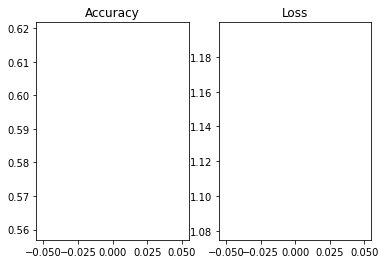

In [58]:
plt.subplot(1, 2, 1)
plt.plot(list(range(nb_epochs)), train_accs, label="Train")
plt.plot(list(range(nb_epochs)), val_accs, label="Val")
plt.title("Accuracy")
plt.subplot(1, 2, 2)
plt.plot(list(range(nb_epochs)), train_losses, label="Train")
plt.plot(list(range(nb_epochs)), val_losses, label="Val")
plt.title("Loss")

### Testing

In [ ]:
test_acc, test_loss = eval_model(vgg, test_loader, cross_entropy)
test_acc, test_loss